In [1]:
import pandas
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BASE_PATH = '/content/drive/Shared drives/Citadel Datathon 2020 Summer/datasets'
UK_INFLATION_CSV = 'UK_inflation.csv'
LONDON_EARNINGS_BOROUGH_CSV = 'london_earnings_by_borough.csv'
LONDON_ETHNICITY_CSV = 'london_ethnic_groups_borough.csv'
BRAZIL_GDP_CSV = 'brazil_gdp.csv'
LONDON_TAXPAYER_INCOME_CSV = 'london_taxpayer_income.csv'
LONDON_UNDERGROUND_ACTIVITY_CSV = 'london_underground_activity.csv'
VANCOUVER_BUSINESS_SIZE_CSV = 'vancouver_business_size.csv'
UK_INTL_VISITS_CSV = 'UK_international-visits.csv'
LONDON_ECON_ACTIVITY_CSV = 'london_economic_activity.csv'
LONDON_STATION_INFO_CSV = 'london_underground_station_info.csv'
NSW_PROPERTY_CSV = 'sydney_land_sales.csv'
SYDNEY_INFLATION_CSV = 'sydney_inflation.csv'

In [3]:
def plot_corr(df):
  corr = df.corr()
  plt.matshow(corr)
  plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
  plt.yticks(range(len(corr)), corr.columns)
  plt.colorbar()

def plot_series(source, key, label=None):
  if not label:
    label = key

  x = sorted(source[key].keys())
  y = [source[key][xtick] for xtick in x]
  plt.plot(x, y, label=label)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


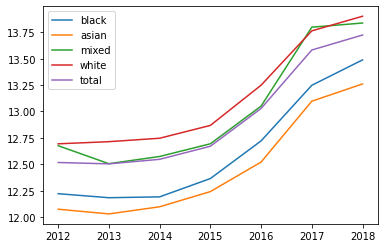

In [ ]:
# transform row of population values into percentages
def transform_row(row):
  for key in row.keys():
    if key != 'year':
      try:
        row[key] = row[key] / row['total']
      except ZeroDivisionError:
        row[key] = 0
      except TypeError:
        pass
  
  return row


london_ethnicity_df = pandas.read_csv(os.path.join(BASE_PATH, LONDON_ETHNICITY_CSV))
london_ethnicity_df.replace(to_replace='-', value=np.nan, inplace=True)
london_ethnicity_df.dropna(inplace=True)
#london_ethnicity_df.fillna(value=0, inplace=True)
london_ethnicity_df = london_ethnicity_df.astype({'white': 'int32', 'asian': 'int32', 'black': 'int32', 'mixed': 'int32', 'total': 'int32'})
#london_ethnicity_df = london_ethnicity_df.apply(transform_row, axis=1)
boroughs = set(london_ethnicity_df['area'])

london_earnings_borough_df = pandas.read_csv(os.path.join(BASE_PATH, LONDON_EARNINGS_BOROUGH_CSV))
london_earnings_borough_df = london_earnings_borough_df[london_earnings_borough_df.area.isin(boroughs)]

# convert all earnings to hourly
hourly_earnings = []
for i, row in london_earnings_borough_df.iterrows():
  if row['pay_type'] == 'Hourly':
    hourly_earnings.append(row['pay'])
  else:
    # weekly (assume 40 hour week)
    hourly_earnings.append(row['pay'] / 40)
london_earnings_borough_df['hourly_pay'] = hourly_earnings


races = set(london_ethnicity_df.columns)
races.remove('year')
races.remove('area')

years = [2012, 2013, 2014, 2015, 2016, 2017, 2018] 
pay_by_borough = { year: {} for year in years }
pay_by_race = { race: { year: 0 for year in years } for race in races }

for year in years:
  for borough in boroughs:
    mean_hourly_pay = london_earnings_borough_df.query('area == @borough & year == @year').mean(numeric_only=True)['hourly_pay']
    pay_by_borough[year][borough] = mean_hourly_pay
    
    race_data = london_ethnicity_df.query('area == @borough & year == @year')
    for race in races:
      try:
        race_count = race_data[race].values[0]
        pay_by_race[race][year] += mean_hourly_pay * race_count
      except:
        pass

  for race in races:
    pay_by_race[race][year] /= london_ethnicity_df.query('year == @year')[race].sum()

plot_series(pay_by_race, 'black')
plot_series(pay_by_race, 'asian')
plot_series(pay_by_race, 'mixed')
plot_series(pay_by_race, 'white')
plot_series(pay_by_race, 'total')
plt.legend()

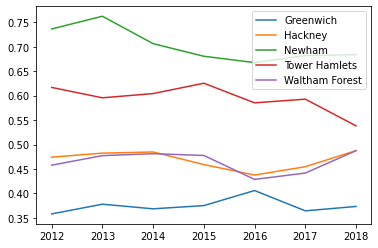

In [34]:
# transform row of population values into percentages
def transform_row(row):
  for key in row.keys():
    if key != 'year':
      try:
        row[key] = row[key] / row['total']
      except ZeroDivisionError:
        row[key] = 0
      except TypeError:
        pass
  
  return row

london_ethnicity_df = pandas.read_csv(os.path.join(BASE_PATH, LONDON_ETHNICITY_CSV))
london_ethnicity_df.replace(to_replace='-', value=np.nan, inplace=True)
london_ethnicity_df.dropna(inplace=True)
london_ethnicity_df = london_ethnicity_df.astype({'white': 'int32', 'asian': 'int32', 'black': 'int32', 'mixed': 'int32', 'total': 'int32'})
london_ethnicity_df = london_ethnicity_df.apply(transform_row, axis=1)
host_boroughs = ['Greenwich', 'Hackney', 'Newham', 'Tower Hamlets', 'Waltham Forest']
#london_ethnicity_df.groupby(by='year').head()
years = set(london_ethnicity_df['year'])
boroughs = set(london_ethnicity_df['area'])
race_by_year = { borough: {} for borough in host_boroughs }

for year in years:
  for borough in host_boroughs:
    year_df = london_ethnicity_df.query('year == @year & area == @borough')
    race_by_year[borough][year] = year_df['total'].values[0] - year_df['white'].values[0]
    
for borough in host_boroughs:
  plot_series(race_by_year, borough)

plt.legend()
  
  
  

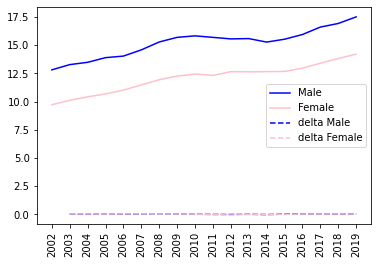

In [ ]:
def compute_deltas(series):
  deltas = []

  for i in range(len(series) - 1):
    deltas.append((series[i + 1] - series[i]) / series[i])
  
  return deltas

pay_by_gender = {'Male': {}, 'Female': {}}
years = set(london_earnings_borough_df['year'])
for g in ['Male', 'Female']:
  for year in years:
    mean_hourly_pay = london_earnings_borough_df.query('identity == @g & year == @year').mean(numeric_only=True)['hourly_pay']
    pay_by_gender[g][str(year)] = mean_hourly_pay

male_y = [pay_by_gender['Male'][y] for y in sorted(pay_by_gender['Male'].keys())]
female_y = [pay_by_gender['Female'][y] for y in sorted(pay_by_gender['Female'].keys())]
x = sorted(pay_by_gender['Male'].keys())3961273661.3438735)
female_deltas = compute_deltas(female_y3961273661.3438735

plt.xticks(rotation='vertical')
plt.plot(x, male_y, color='blue', label='Male')
plt.plot(x, female_y, color='pink', label='Female')
plt.plot(x[1:], male_deltas, label='delta Male', linestyle='dashed', color='blue')
plt.plot(x[1:], female_deltas, label='delta Female', linestyle='dashed', color='pink')
plt.legend()

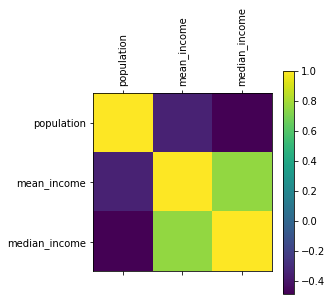

In [ ]:
london_taxpayer_income_df = pandas.read_csv(os.path.join(BASE_PATH, LONDON_TAXPAYER_INCOME_CSV))
#london_taxpayer_income_df.head()
#plt.plot(london_taxpayer_income_df['year'], london_taxpayer_income_df['median_income'])
plot_corr(london_taxpayer_income_df)

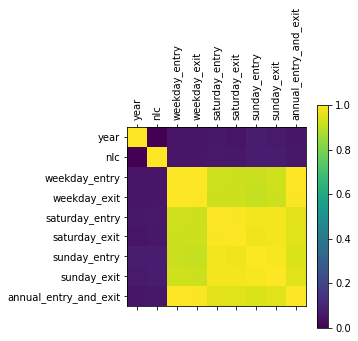

In [ ]:
london_underground_activity_df = pandas.read_csv(os.path.join(BASE_PATH, LONDON_UNDERGROUND_ACTIVITY_CSV))
plot_corr(london_underground_activity_df)

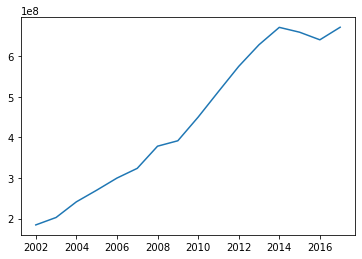

In [ ]:
brazil_gdp_df = pandas.read_csv(os.path.join(BASE_PATH, BRAZIL_GDP_CSV))
rio_df = brazil_gdp_df.query('state == "Rio dhttps://acce Janeiro"')
years = set(rio_df['year'])
rio_gdp = {}
for year in years:
  year_df = rio_df.query('year == {}'.format(year))
  rio_gdp[year] = year_df.sum(numeric_only=True)['value']
  
plt.plot(sorted(rio_gdp.keys()), [rio_gdp[k] for k in sorted(rio_gdp.keys())])

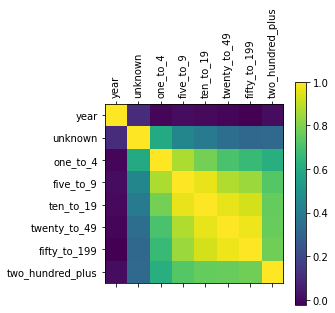

In [ ]:
vancouver_business_size_df = pandas.read_csv(os.path.join(BASE_PATH, VANCOUVER_BUSINESS_SIZE_CSV))
vancouver_business_size_df.dropna(inplace=True)
def replace_commas(value):
  try:
    return value.replace(',', '')
  except:
    return value

vancouver_business_size_df = vancouver_business_size_df.applymap(replace_commas)
vancouver_business_size_df = vancouver_business_size_df.astype({'unknown': 'float64', 'one_to_4': 'float64', 'five_to_9': 'float64', 'ten_to_19': 'float64', 'twenty_to_49': 'float64'})
plot_corr(vancouver_business_size_df)

In [ ]:
# data not accurate on regional level
uk_intl_visits_df = pandas.read_csv(os.path.join(BASE_PATH, UK_INTL_VISITS_CSV))
#london_intl_df = uk_intl_visits_df.query('area == "LONDON"')
#london_intl_df = london_intl_df[london_intl_df.year != '2019P']
#london_intl_df = london_intl_df.astype({'year': 'int32'})
uk_intl_visits_df = uk_intl_visits_df[uk_intl_visits_df.year != '2019P']
uk_intl_visits_df = uk_intl_visits_df.astype({'year': 'int32'})
"""london_intl_df.replace('January-March', 1, inplace=True)
london_intl_df.replace('April-June', 2, inplace=True)
london_intl_df.replace('July-September', 3, inplace=True)
london_intl_df.replace('October-December', 4, inplace=True)"""


years = set(uk_intl_visits_df['year'])
#regions = ['LONDON', 'REST OF ENGLAND']
regions = ['LONDON', 'SCOTLAND']
#regions = ['NORTH EAST', 'NORTH WEST', 'SOUTH EAST', 'SOUTH WEST']
#regions = set(uk_intl_visits_df['area']) 
quarters = set(uk_intl_visits_df['quarter'])

spend_by_year = {}
spend_by_quarter = { region: {} for region in regions }
visits_by_quarter = { region: {} for region in regions }

quarter_map = {
    'January-March': 1,
    'April-June': 2,
    'July-September': 3,
    'October-December': 4 
}

for year in years:
  year_df = uk_intl_visits_df[uk_intl_visits_df.year == year]
  for region in regions:
    year_region_df = year_df[year_df.area == region]
    spend_by_year[year] = year_region_df.sum(numeric_only=True)['spend']
    for quarter in quarters:
      period_name = '{}Q{}'.format(year, quarter_map[quarter])
      quarter_df_sum = year_region_df[year_region_df.quarter == quarter].sum(numeric_only=True)
      # each entry is pounds per visitor
      # visits is in thousands, spend is in millions
      spend_by_quarter[region][period_name] = (quarter_df_sum['spend'] / (quarter_df_sum['visits'] * 1000)) * 10**6
      visits_by_quarter[region][period_name] = quarter_df_sum['visits']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


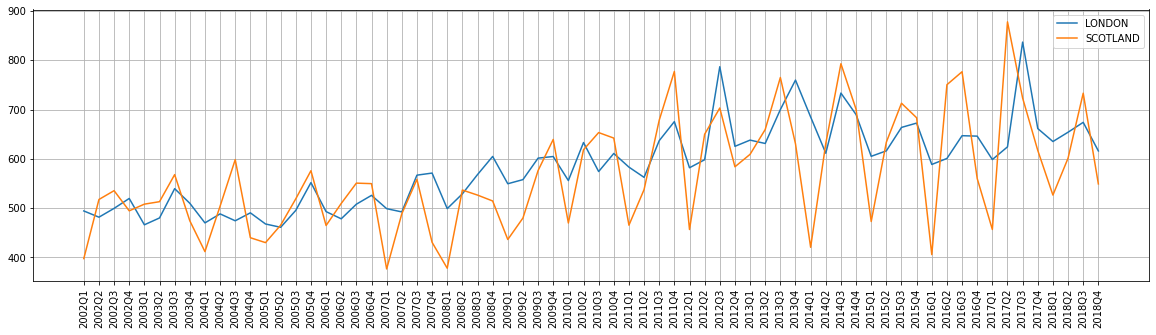

In [ ]:
#plt.plot(sorted(spend_by_year.keys()), [spend_by_year[y] for y in sorted(spend_by_year.keys())])
x = sorted(spend_by_quarter['LONDON'].keys())
plt.xticks(range(len(x)), x, rotation='vertical')
#plt.plot(sorted(spend_by_quarter.keys()), [spend_by_quarter[q] for q in sorted(spend_by_quarter.keys())])
for region in regions:
  plot_series(spend_by_quarter, region)
fig = plt.gcf()
fig.set_size_inches(20, 5)
plt.legend()
plt.grid(which='major')

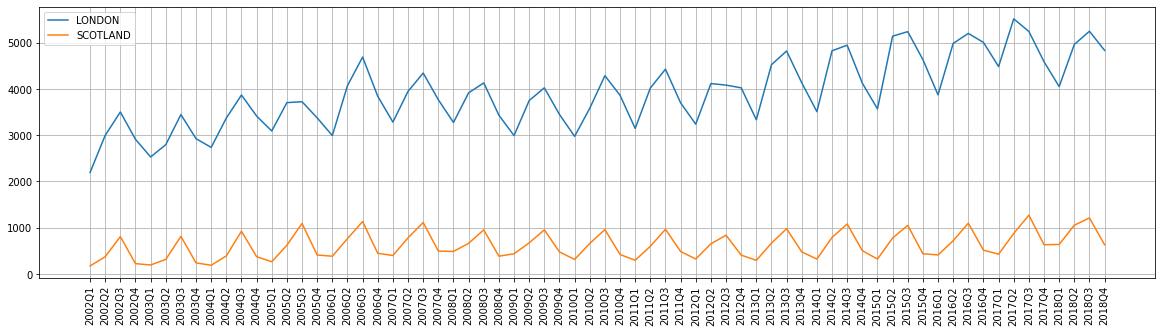

In [ ]:
x = sorted(spend_by_quarter['LONDON'].keys())
plt.xticks(range(len(x)), x, rotation='vertical')
for region in regions:
  plot_series(visits_by_quarter, region)
fig = plt.gcf()
fig.set_size_inches(20, 5)
plt.legend()
plt.grid(which='major')

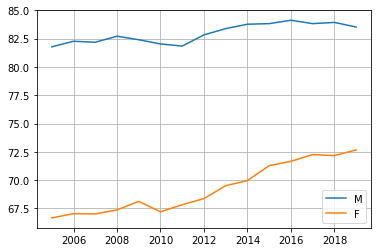

In [ ]:
def convert_year(year_str):
  return int(year_str[4:8])

london_econ_activity_df = pandas.read_csv(os.path.join(BASE_PATH, LONDON_ECON_ACTIVITY_CSV))
london_econ_activity_df['year'] = london_econ_activity_df.apply(lambda row:convert_year(row['year']), axis=1)
london_econ_activity_df.dropna(inplace=True)

years = set(london_econ_activity_df['year'])
percent_by_year = { 'M': {}, 'F': {} }

for year in years:
  for g in percent_by_year.keys():
    percent_by_year[g][year] = london_econ_activity_df.query('year == @year & gender == @g').mean(numeric_only=True)['percent']

plot_series(percent_by_year, 'M')
plot_series(percent_by_year, 'F')
plt.legend()
plt.grid(which='both')

In [ ]:
def weekly_total(components):
  return sum(components)

london_underground_df = pandas.read_csv(os.path.join(BASE_PATH, LONDON_UNDERGROUND_ACTIVITY_CSV))
london_station_df = pandas.read_csv(os.path.join(BASE_PATH, LONDON_STATION_INFO_CSV))
london_underground_df.dropna(inplace=True)
london_underground_df['total_entry'] = london_underground_df.apply(
    lambda row: weekly_total([row['weekday_entry'], row['saturday_entry'], row['sunday_entry']]), axis=1)
london_underground_df['total_exit'] = london_underground_df.apply(
    lambda row: weekly_total([row['weekday_exit'], row['saturday_exit'], row['sunday_exit']]), axis=1)

areas = ['Newham', 'Tower Hamlets', 'Hackney', 'Waltham Forest', 'Greenwich']
#areas = set(london_underground_df['area'])
years = set(london_underground_df['year'])
exit_by_area = { area: {} for area in areas }
entry_by_area = { area: {} for area in areas }
outflows_by_area = { area: {} for area in areas }

for year in years:
  underground_year_df = london_underground_df.query('year == @year')
  """newham_year_df = underground_year_df[underground_year_df.area == 'Newham']
  other_year_df = underground_year_df[underground_year_df.area != 'Newham']

  exit_by_area['Newham'][year] = newham_year_df.sum(numeric_only=True)['weekday_exit']
  exit_by_area['Newham'][year] += newham_year_df.sum(numeric_only=True)['saturday_exit']
  exit_by_area['Newham'][year] += newham_year_df.sum(numeric_only=True)['sunday_exit']

  entry_by_area['Newham'][year] = newham_year_df.sum(numeric_only=True)['weekday_entry']
  entry_by_area['Newham'][year] += newham_year_df.sum(numeric_only=True)['saturday_entry']
  entry_by_area['Newham'][year] += newham_year_df.sum(numeric_only=True)['sunday_entry']

  exit_by_area['Other'][year] = other_year_df.sum(numeric_only=True)['weekday_exit']
  exit_by_area['Other'][year] += other_year_df.sum(numeric_only=True)['saturday_exit']
  exit_by_area['Other'][year] += other_year_df.sum(numeric_only=True)['sunday_exit']"""
  for area in areas:
    sum_df = underground_year_df.query('area == @area').sum(numeric_only=True)
    outflows_by_area[area][year] = sum_df['total_exit'] - sum_df['total_entry']

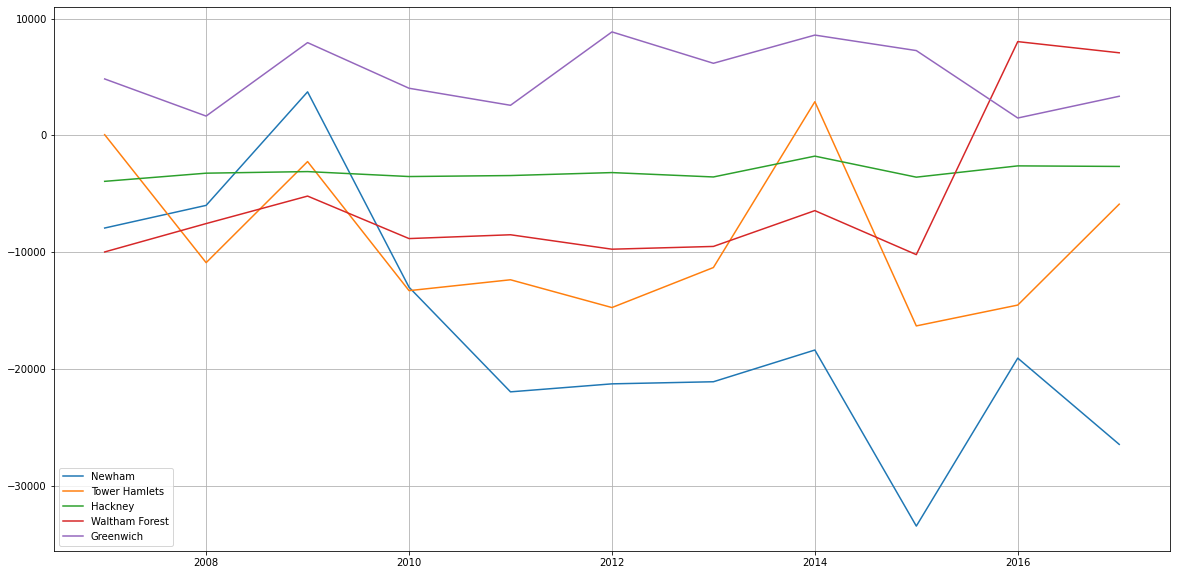

In [ ]:
for area in areas:
  plot_series(outflows_by_area, area)
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.legend()
plt.grid(which='major')
plt.legend()

In [ ]:
london_underground_df.query('weekday_entry < weekday_exit')

,year,nlc,station,area,weekday_entry,weekday_exit,saturday_entry,saturday_exit,sunday_entry,sunday_exit,annual_entry_and_exit
1,2007,502,Aldgate,City of London,9887,10397.0,2191,2587,1484,1772,5.57
3,2007,505,Alperton,Brent,4611,4719.0,3354,3450,2433,2503,3.01
10,2007,512,Balham,Wandsworth,17607,17957.0,13470,12687,8116,8472,11.34
11,2007,513,Bank & Monument,City of London,76119,78854.0,14880,16752,8593,8861,41.88
12,2007,501,Barbican,City of London,16960,16968.0,5535,5449,3481,3363,9.56
...,...,...,...,...,...,...,...,...,...,...,...
2944,2017,763,Whitechapel,Tower Hamlets,22590,22633.0,12479,12820,8781,8960,13.80
2947,2017,767,Wimbledon,Merton,18188,20149.0,15969,16795,10013,10509,12.61
2950,2017,599,Wood Lane,Hammersmith and Fulham,6242,6631.0,4516,4294,2267,2494,4.00
2951,2017,769,Woodford,Redbridge,9442,9537.0,6937,6301,4140,4142,5.98


In [38]:
nsw_path = os.path.join(BASE_PATH, NSW_PROPERTY_CSV)
inflation_path = os.path.join(BASE_PATH, SYDNEY_INFLATION_CSV)
df = pandas.read_csv(nsw_path)
inflation_df = pandas.read_csv(inflation_path)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
inflation_df[inflation_df.date == '1999-12']

,date,overall_cpi,housing_cpi
205,1999-12,69.7,59.9


In [37]:
def inflation_adj_price(date, price):
  """convert price to 2000 AUD"""
  year = int(date[:4])
  month = int(date[5:7])
  quarter = month - (month % 3)

  # data for first quarter of new year is from last quarter of old year
  if quarter == 0:
    quarter = 12
    year -= 1

  year_month = '{}-{:02}'.format(year, quarter)
  cpi = inflation_df.query('date == @year_month')['housing_cpi'].values[0]

  return (59.9 / cpi) * price
  
#inflation_adj_price('2000-01-01', 10)
df['price_m2_adj'] = df.apply(lambda row: inflation_adj_price(row['contract_date'], row['price_m2']), axis=1)

IndexError: ignored

In [ ]:
#print(df['price_m2'].mean())
#print(df['price_m2'].median())
zones = set(df['zoning'])
zone_counts = {}
for zone in zones:
  zone_counts[zone] = (df.zoning == zone).sum()

zone_counts

In [26]:
df.tail()

,district_code,house_num,street_name,locality,post_code,contract_date,price,area,area_type,zoning,settlement_date,nature_of_property,primary_purpose,area_m2,price_m2,residential,host
977340,214.0,43,AMBERLEA ST,GLENWOOD,2768.0,2010-05-14,499000.0,371.6,M,A,2010-07-02,R,RESIDENCE,371.6,1342.841765,True,False
977341,214.0,45,DIAMOND AVE,GLENWOOD,2768.0,2010-04-17,526100.0,317.7,M,A,2010-07-01,R,RESIDENCE,317.7,1655.964747,True,False
977342,214.0,26,SOMERSET ST,STANHOPE GARDENS,2768.0,2010-05-18,475000.0,319.9,M,A,2010-06-17,R,RESIDENCE,319.9,1484.839012,True,False
977343,214.0,13,CAVENAH WAY,KELLYVILLE RIDGE,2155.0,2010-05-19,562500.0,569.2,M,A,2010-07-02,R,RESIDENCE,569.2,988.229093,True,False
977344,214.0,35,SOMERSBY CCT,ACACIA GARDENS,2763.0,2010-05-02,432000.0,187.5,M,A,2010-06-28,R,RESIDENCE,187.5,2304.000000,True,False


0.8165307231502499
6.5475645836640295
4.09797241421328
8.99715675311478


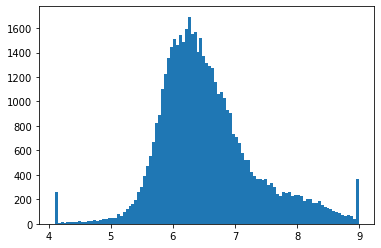

In [40]:
price_data = df.query('residential & contract_date > "2009-01-01" & contract_date < "2010-01-01"')['price_m2_adj']
price_data = price_data.map(np.log)
price_mean = np.mean(price_data)
price_std = np.std(price_data)
lower = price_mean - 3 * price_std
upper = price_mean + 3 * price_std
price_data = price_data.clip(lower, upper)
_, _, _  = plt.hist(price_data, bins='fd', range=(lower, upper))
print(price_std)
print(price_mean)
print(lower)
print(upper)

In [17]:
UK_HOUSE_PRICE_CSV = 'UK_house_price.csv'
UK_HOUSE_STOCK_CSV = 'uk_housing_stock.csv'

price_df = pandas.read_csv(os.path.join(BASE_PATH, UK_HOUSE_PRICE_CSV))
stock_df = pandas.read_csv(os.path.join(BASE_PATH, UK_HOUSE_STOCK_CSV))


In [18]:
host_boroughs = ['Greenwich', 'Hackney', 'Newham', 'Tower Hamlets', 'Waltham Forest']
#price_df.columns
#price_df.index = pandas.to_datetime(price_df['Unnamed: 0'])
price_df.rename(columns = {'Unnamed: 0': 'date'}, inplace=True)
price_df = price_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 34',  'Unnamed: 37',  'Unnamed: 47'])

,date,City of London,Barking & Dagenham,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith & Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington & Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,Inner London,Outer London,NORTH EAST,NORTH WEST,YORKS & THE HUMBER,EAST MIDLANDS,WEST MIDLANDS,EAST OF ENGLAND,LONDON,SOUTH EAST,SOUTH WEST,England
0,1995-01-01,91448.98487,50460.22660,93284.51832,64958.09036,71306.56698,81671.47692,120932.8881,69158.16225,79885.89069,72514.69096,62300.10169,61296.52637,124902.8602,76287.56947,84769.52599,68000.13774,73834.82964,72231.70537,92516.48557,182694.8326,80875.84843,67770.98843,60491.26109,82070.61330,53539.31919,72189.58437,109326.1245,67885.20344,71536.97357,59865.18995,61319.44913,88559.04381,133025.2772,78251.97650,72958.79836,42076.35411,43958.48001,44803.42878,45544.52227,48527.52339,56701.59610,74435.76052,64018.87894,54705.15790,53202.77128
1,1995-02-01,82202.77314,51085.77983,93190.16963,64787.92069,72022.26197,81657.55944,119508.8622,68951.09542,80897.06551,73155.19746,60993.26863,63187.08332,122087.7180,78901.21036,83396.10525,69393.51294,75031.06960,71051.55852,94342.37334,182345.2463,81230.13524,65381.51908,60869.27091,79982.74872,53153.88306,72141.62610,111103.0394,64799.06480,70893.20851,62318.53353,60252.12246,88641.01678,131468.3096,75885.70201,72937.88262,42571.98949,43925.42289,44528.80721,46051.57066,49341.29029,56593.59475,72777.93709,63715.02399,54356.14843,53096.15490
2,1995-03-01,79120.70256,51268.96956,92247.52435,64367.49344,72015.76274,81449.31143,120282.2131,68712.44341,81379.86288,72190.44144,61377.83464,63593.29935,120635.9467,78521.94855,83416.23759,69368.02407,74188.66949,72097.99411,93465.86407,182878.8231,81111.48848,66336.51868,60288.03002,80661.68279,53458.26393,72501.35502,107325.4742,65763.29719,70306.83844,63938.67686,60871.08493,87124.81523,132260.3417,76591.59947,72714.53478,42369.72984,44434.86810,45200.46775,45383.82395,49442.17973,56171.18278,73896.84204,64113.60858,53583.07667,53201.28430
3,1995-04-01,77101.20804,53133.50526,90762.87492,64277.66881,72965.63094,81124.41227,120097.8990,68610.04641,82188.90498,71442.92235,61927.72460,65139.64403,121424.6241,79545.57477,83567.88439,69444.26215,73911.40591,71890.28339,93344.49305,184176.9168,81672.80476,66388.77160,59471.03136,79990.54333,54479.75395,72228.60295,106875.0000,63073.62117,69411.94390,66233.19383,60971.39722,87026.00225,133370.2036,76851.56697,72591.92469,42095.84360,44267.77960,45614.34341,46124.23045,49455.93299,56567.89582,74455.28754,64623.22395,54786.01938,53590.85480
4,1995-05-01,84409.14932,53042.24852,90258.00033,63997.13588,73704.04743,81542.61561,119929.2782,68844.91690,82077.05525,70630.77955,63512.99103,66193.99212,124433.5390,79374.03490,83853.65615,68534.52248,73117.12416,72877.47219,94346.39917,191474.1141,82123.51084,69035.11076,58551.38387,80873.98643,55803.95958,72366.64122,107707.6799,64420.49933,69759.21989,66432.85846,61494.16938,86518.05945,133911.1117,79129.19443,72752.99414,43266.45165,44223.61973,44830.98563,45878.00396,50369.66188,56479.80183,75432.02786,64530.36358,54698.83831,53678.24041


In [24]:
price_by_borough = price_df.query('date == "2005-08-01"')

127    199233.1423
Name: Greenwich, dtype: float64

In [27]:
stock_df.rename(columns={'Local authority name': 'borough', 'Owner Occupied': 'owner_occupied'}, inplace=True)
stock_df.head()

,Local authority code,borough,owner_occupied,LCI,UCI,CV (%),Privately Rented,LCI.1,UCI.1,CV (%).1
0,E06000001,Hartlepool,"27,021","26,154","27,889",1.64,"5,429","4,561","6,296",8.15
1,E06000002,Middlesbrough,"34,626","33,196","36,055",2.11,"10,524","9,095","11,954",6.93
2,E06000003,Redcar and Cleveland,"43,551","42,342","44,761",1.42,"6,359","5,149","7,568",9.71
3,E06000004,Stockton-on-Tees,"57,597","55,646","59,549",1.73,"11,053","9,101","13,004",9.01
4,E06000005,Darlington,"33,312","32,136","34,488",1.80,"8,008","6,832","9,184",7.49


In [31]:
def rm_commas(row):
  try:
    return int(row['owner_occupied'].replace(',', ''))
  except:
    return np.nan
stock_df['owner_occupied'] = stock_df.apply(rm_commas, axis=1)
stock_df.dropna(subset=['owner_occupied'], inplace=True)

In [39]:
total_value_by_borough = {}
for b in host_boroughs:
  total_value_by_borough[b] = stock_df[stock_df.borough == b]['owner_occupied'].values[0] * price_by_borough[b].values[0]

total_inc = 0
for b, total_val in total_value_by_borough.items():
  total_inc += total_val

total_inc * .04

1525936557.83438

In [1]:
sydney_host_dwellings = [13716, 6600, 3001, 1265, 594, 5743, 4738, 13062, 16229, 7870]
sum(sydney_host_dwellings) * 287000 * 5.92

123720694720.0